# Trabalho 2

## DCA0133 - APRENDIZAGEM DE MÁQUINA E MINERAÇÃO DE DADOS

### 20190152879 - Angelo Marcelino Cordeiro

### 20190153007 - Richardson Santiago Teles de Menezes



In [1]:
import pandas as pd

dataset = pd.read_csv('tesla_data.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y')

dataset.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


### O dataset contém as seuintes colunas:

- **Date**: A data
- **Open**: O preço de abertura da ação
- **High**: O preço alto daquele dia
- **Low**:  O preço mais baixo daquele dia 
- **Close**: O preço de fechamento daquele dia
- **Volume**: A quantidade de ações negociadas durante aquele dia
- **Adj Close**: O preço de fechamento das ações que foi alterado para incluir quaisquer distribuições / ações corporativas que ocorram antes da abertura dos próximos dias


### Esse trabalho focará na predição dos valores de fechamento das ações


## Exploratory Data Analysis

In [2]:
closed_price = dataset[['Date', 'Close']]
closed_price.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [3]:
closed_price.describe()

,Close
count,1692.000000
mean,132.428658
std,94.313187
min,15.800000
25%,29.884999
50%,158.160004
75%,220.022503
max,286.040009


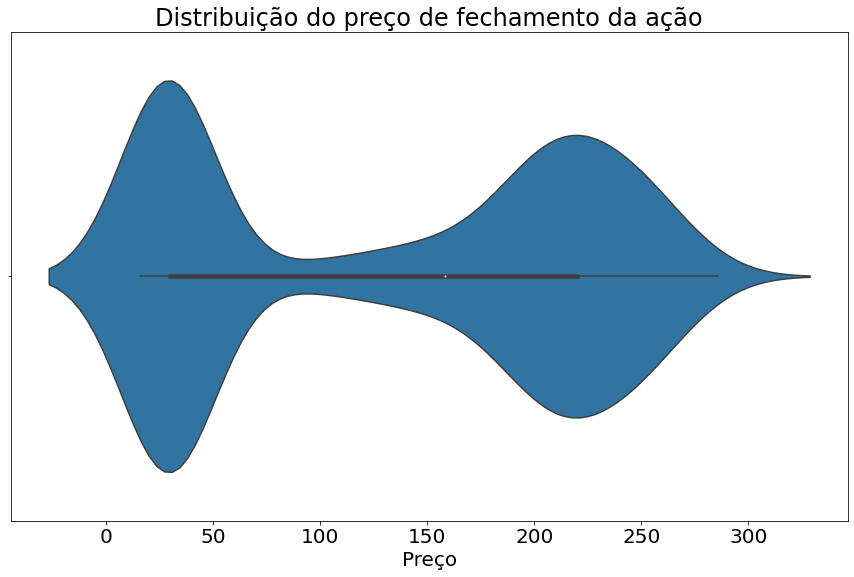

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(15, 9))
sns.violinplot(data=closed_price, x='Close', ax=ax)

ax.set(
    title='Distribuição do preço de fechamento da ação',
    xlabel= 'Preço'
)

plt.show()


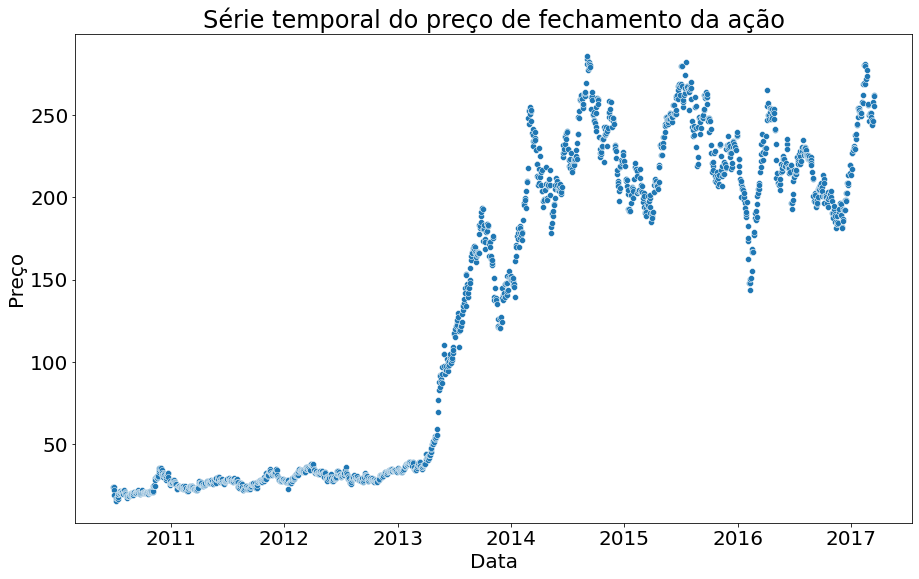

In [5]:
fig, ax = plt.subplots(figsize=(15, 9))

sns.scatterplot(data=closed_price, x='Date', y='Close', ax=ax)

ax.set(
    title='Série temporal do preço de fechamento da ação',
    xlabel='Data',
    ylabel= 'Preço'
)

plt.show()

## Separação dos conjuntos de treino e teste

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

len_data = closed_price.shape[:1][0]
data = closed_price['Close'].values.reshape(len_data, 1)

feature_scaler = MinMaxScaler()
closed_price['Close'] = feature_scaler.fit_transform(data)

forward_days = 1
look_back = 10
periods = 20

division = len_data - periods * look_back

train_df = closed_price.iloc[:division, :]
test_df = closed_price.iloc[division - look_back:, :]

train_data = train_df['Close'].values.reshape(len(train_df), 1)
test_data = test_df['Close'].values.reshape(len(test_df), 1)


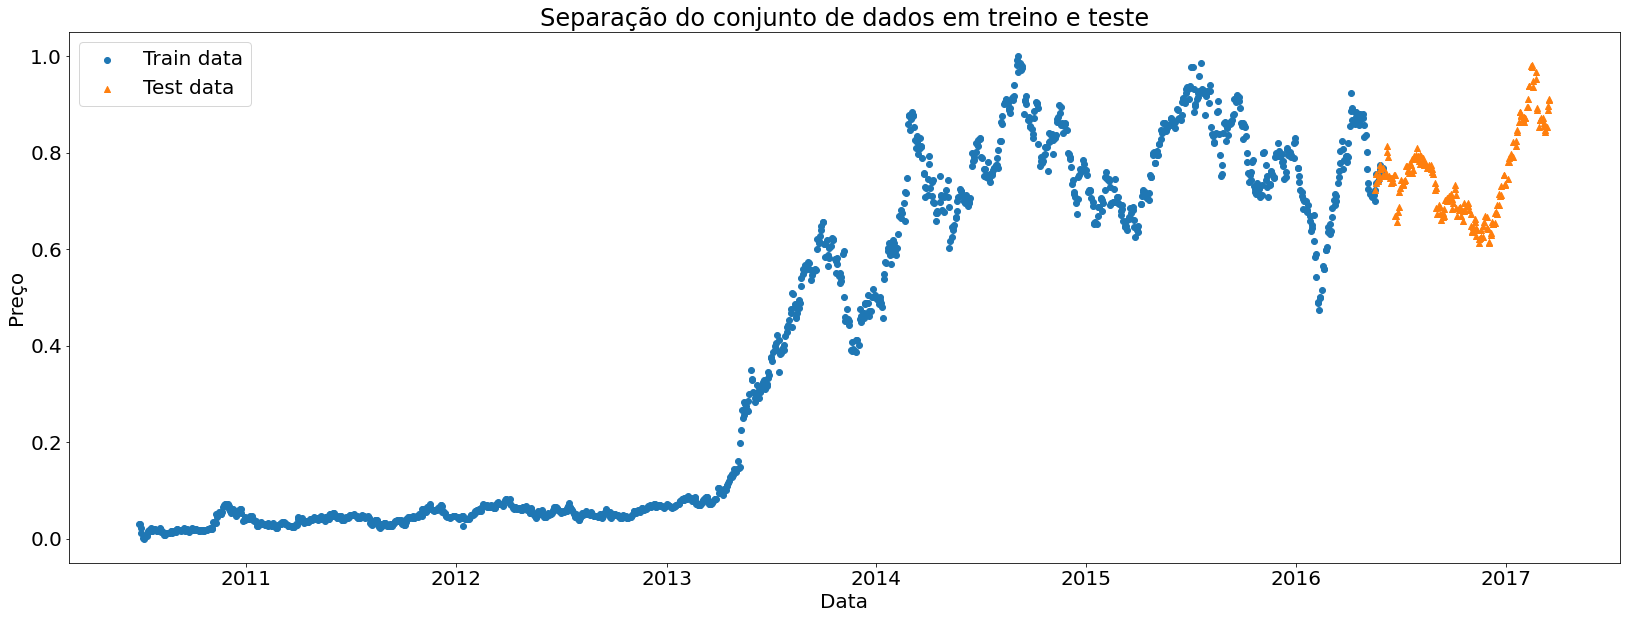

In [6]:
fig, ax = plt.subplots(figsize=(23, 9))

ax.scatter(train_df['Date'], train_df['Close'], marker='o', label='Train data')
ax.scatter(test_df['Date'], test_df['Close'], marker='^', label='Test data')

ax.set(
    title='Separação do conjunto de dados em treino e teste',
    xlabel='Data',
    ylabel= 'Preço'
)

plt.legend()
plt.tight_layout()
plt.show()

In [7]:
train_x, train_y = [], []
test_x, test_y = [], []

for i in range(0, len(train_data) - forward_days - look_back + 1):
    train_x.append(train_data[i : i + look_back])
    train_y.append(train_data[i + look_back : i + look_back + forward_days])

for i in range(0, len(test_data) - forward_days - look_back + 1):
    test_x.append(test_data[i : i + look_back])
    test_y.append(test_data[i + look_back : i + look_back + forward_days])

x_train = np.array(train_x)
x_test = np.array(test_x)

y_train = np.array([list(i.ravel()) for i in train_y])
y_test = np.array([list(i.ravel()) for i in test_y])


## Modelo

In [8]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(128, input_shape=(look_back, 1), return_sequences=True),
    LSTM(64, input_shape=(128, 1)),
    Dense(forward_days)
])

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(
    x_train, y_train, 
    epochs=10, 
    shuffle=True, 
    batch_size=4
)

Epoch 1/10
371/371 [==============================] - 2s 4ms/step - loss: 0.0033
Epoch 2/10
371/371 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 3/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 4/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 5/10
371/371 [==============================] - 2s 5ms/step - loss: 8.8969e-04
Epoch 6/10
371/371 [==============================] - 2s 5ms/step - loss: 5.5116e-04
Epoch 7/10
371/371 [==============================] - 2s 5ms/step - loss: 5.0069e-04
Epoch 8/10
371/371 [==============================] - 2s 5ms/step - loss: 5.6852e-04
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 4.8723e-04
Epoch 10/10
371/371 [==============================] - 2s 5ms/step - loss: 4.5472e-04


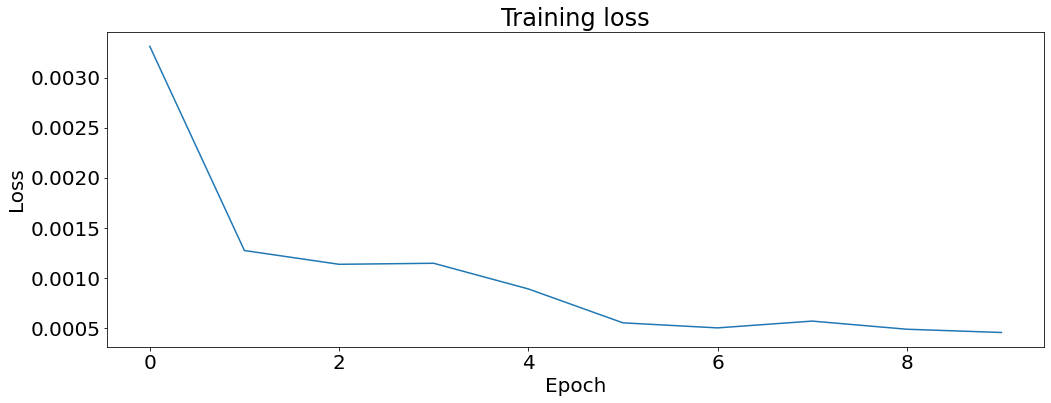

In [10]:
fig, axes = plt.subplots(figsize=(15, 6))

axes.plot(history.history['loss'])

axes.set(
    title='Training loss',
    ylabel='Loss',
    xlabel='Epoch'
)

plt.tight_layout()
plt.show()

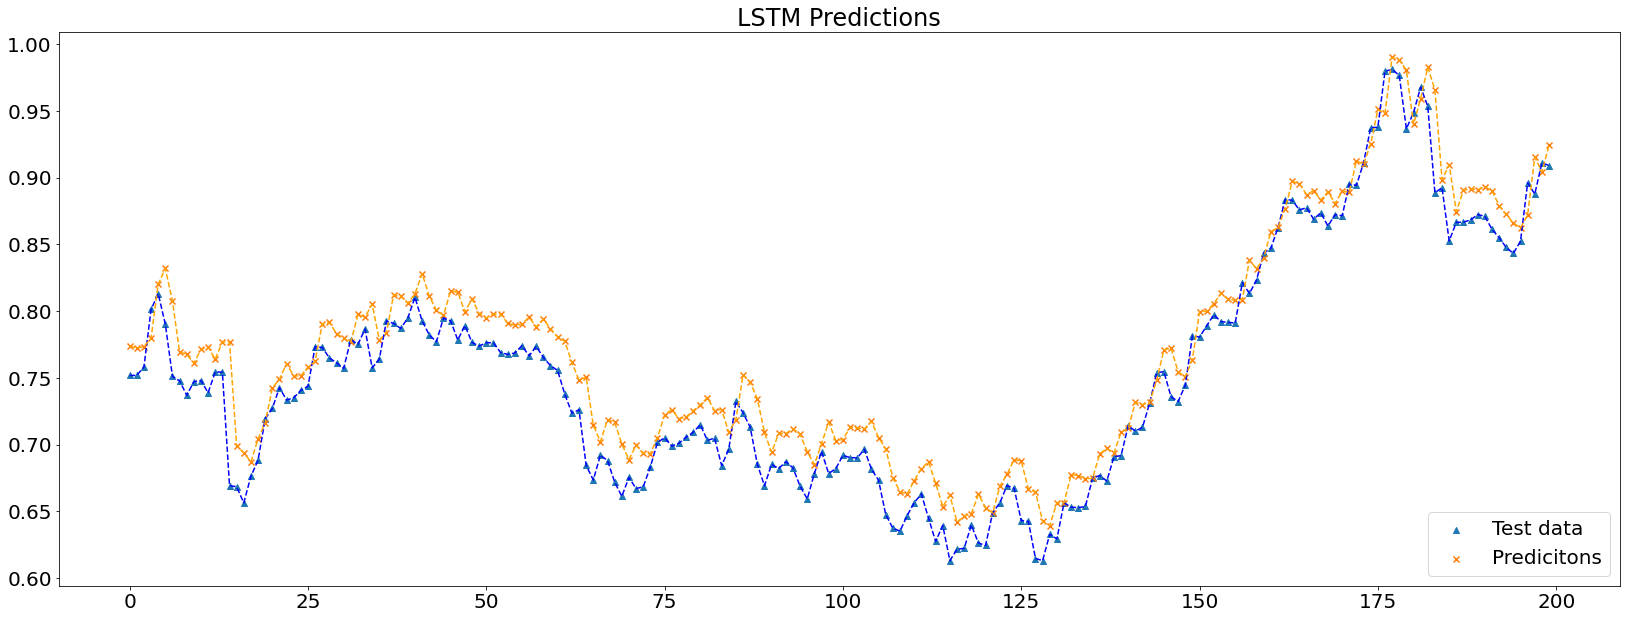

In [13]:
y_pred = model.predict(x_test)
error = np.abs(y_test - y_pred)

fig, ax = plt.subplots(figsize=(23, 9))

ax.plot(range(len(y_test)), y_test, 'b--')
ax.scatter(range(len(y_test)), y_test, marker='^', label='Test data')

ax.plot(range(len(y_pred)), y_pred, '--', color='orange')
ax.scatter(range(len(y_pred)), y_pred, marker='x', label='Predicitons')

ax.set(
    title='LSTM Predictions'
)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()